In [37]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from tqdm import tqdm
from rapidfuzz import fuzz
from matplotlib import colors 
import networkx as nx
from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%autoreload 2

# Data

In [39]:
DATA_FOLDER = "../Data/"
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [40]:
actors = actors_load.copy()
movies = movies_load.copy()

In [41]:
actors_exploded = explode_on_movies(actors)

# Ethnicities map

# Data

In [42]:
actors.head()

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner
0,/m/010p3,adam carolla,M,1964-05-27,1.88,/m/0xnvg,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN
1,/m/010q36,fred rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN
2,/m/010wx,aria giovanni,F,1977-11-03,1.68,/m/03q819,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN
3,/m/010xjr,richard harris,M,1930-10-01,1.85,/m/03bkbh,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False}
4,/m/0112yl,toshiro mifune,M,1920-04-01,1.74,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN


In [43]:
movies.head()

,fbID,movieName,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,...,averageRating,numVotes,budget_x,popularity_x,budget_y,popularity_y,budget,popularity,combinedGenres,genres
0,/m/08yl5d,getting away with murder the jonbenet ramsey m...,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"['Mystery', 'Biographical film', 'Drama', 'Cri...",2.0,2000.0,tt0245916,...,6.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'Drama', 'Crime Drama', 'Mystery', 'Biographi...","{Drama, Mystery, Crime}"
1,/m/0crgdbh,brun bitter,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"['Crime Fiction', 'Drama']",NaN,1988.0,tt0094806,...,5.6,40.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'Drama', 'Crime Fiction', 'Crime'}","{Drama, Fiction, Crime}"
2,/m/0285_cd,white of the eye,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"['Thriller', 'Erotic thriller', 'Psychological...",NaN,1987.0,tt0094320,...,6.1,2885.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'Mystery', 'Erotic thriller', 'Psychological ...","{Horror, Mystery, Thriller}"
3,/m/01mrr1,a woman in flames,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},['Drama'],NaN,1983.0,tt0083949,...,6.0,621.0,NaN,NaN,NaN,NaN,NaN,NaN,{'Drama'},{Drama}
4,/m/03cfc81,the gangsters,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"['Short Film', 'Silent film', 'Indie', 'Black-...",5.0,1913.0,tt0002894,...,6.8,16.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'Indie', 'Short Film', 'Short', 'Silent film'...","{Black-and-white, Silent, Indie, Short, Comedy}"


# Clean

In [44]:
winner_actors_ID = actors_exploded[actors_exploded["winner"]==True]["fbActorID"].to_list()

In [45]:
winner_actors_exp = actors_exploded.loc[
    actors_exploded["fbActorID"].isin(winner_actors_ID)
]

In [46]:
winner_actors_exp['actorDOB'] = pd.to_datetime(winner_actors_exp['actorDOB']).dt.year

In [93]:
winner_actors = winner_actors_exp.groupby(
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
    ],
    dropna=False
).apply(actors_agg).reset_index().set_index("actorName")

# Network

In [94]:
import networkx as nx

In [95]:
actorNames = winner_actors.index
actorMovies = winner_actors["fbID"]

In [96]:
G = nx.Graph()
edge_attribute_dict = {}

In [97]:
movies_IDs = movies["fbID"].to_list()

In [99]:
for actor_name_x, movie_ids_x in zip(actorNames, actorMovies):
    G.add_node(actor_name_x)
    for movie_id in movie_ids_x:
        if movie_id in movies_IDs:
            for actor_name_y, movie_ids_y in zip(actorNames, actorMovies):
                if (movie_id in movie_ids_y) and (actor_name_x != actor_name_y):
                    G.add_edge(actor_name_x, actor_name_y)
                    edge_name = tuple(sorted((actor_name_x, actor_name_y)))
                    if edge_name not in edge_attribute_dict:
                        edge_attribute_dict[edge_name] = 1
                    else:
                        edge_attribute_dict[edge_name] += 1

In [100]:
len(edge_attribute_dict)

2002

In [107]:
for k, v in edge_attribute_dict.items():
    edge_attribute_dict[k] = {"weight" : v}

nx.set_edge_attributes(G, edge_attribute_dict)

In [112]:
# add node attributes by passing dictionary of type name -> attribute
nx.set_node_attributes(G, winner_actors['actorGender'].to_dict(), 'actorGender')
nx.set_node_attributes(G, winner_actors['actorDOB'].to_dict(), 'actorDOB')
nx.set_node_attributes(G, winner_actors['actorEthnicity'].to_dict(), 'actorEthnicity')

# Helper functions

In [103]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

# Network analysis

In [63]:
describe_graph(G)


Graph with 245 nodes and 2002 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0670
Global clustering coefficient aka Transitivity: 0.1813


The graph is not connected, meaning there are isolated components within it. This suggests that there are groups of actors who have not collaborated in any films with actors outside their respective groups.

The sparsity of the graph, indicating that the ratio of actual edges to the maximum possible edges is relatively low. This is typical in social networks or collaboration graphs where not every pair of nodes (actors) has worked together.

The global clustering coefficient. This measures the degree to which nodes in the graph tend to cluster together. A higher coefficient suggests that actors who have worked together are likely to have other collaborators in common. The value of 0.2139 indicates a moderate level of clustering.

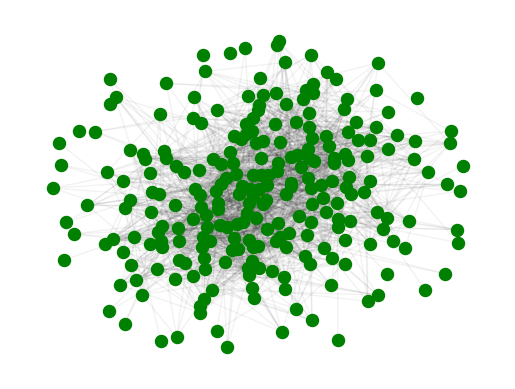

In [64]:
visualize_graph(G, False, k=1, alpha=0.05, node_shape='.')

In [65]:
nx.write_gexf(G, "./Graphs/oscar.gexf")

FileNotFoundError: [Errno 2] No such file or directory: './Graphs/oscar.gexf'

There seem to be a few nodes with many connections (i.e. hubs)

In [66]:
print(nx.is_connected(G))
comp = list(nx.connected_components(G))
print('The graph contains', len(comp), 'connected components')

False
The graph contains 5 connected components


In [67]:
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/G.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has 241 nodes accounting for 98.37 % of the nodes


From visually inspecting the graph, we already saw that most of the nodes are in the largest component

In [72]:
winner_actors.loc[winner_actors.index.get_level_values("actorName") == "Jeff Bridges"]

,,,,,,fbID,ageAtMovieRelease,category,winner
fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,,,,
/m/0flw6,jeff bridges,M,1949,1.85,NaN,"[/m/016kc2, /m/016z43, /m/01kp4q, /m/01tdmp, /...","{'/m/016kc2': 35.0, '/m/01kp4q': 37.0, '/m/01t...","{'/m/016kc2': 'ACTOR IN A LEADING ROLE', '/m/0...","{'/m/016kc2': False, '/m/016z43': None, '/m/01..."


In [75]:
Bridges_Cage_path = nx.shortest_path(G, source="Nicolas Cage", target="Jeff Bridges")
print("Shortest path between Jeff Bridges and Nicolas Cage", Bridges_Cage_path)

Shortest path between Jeff Bridges and Nicolas Cage ['nicolas cage', 'ellen burstyn', 'jeff bridges']


In [77]:
# take the largest component and analyse its diameter = longest shortest-path
lcc_G = G.subgraph(largest_comp)
print("The diameter of the largest connected component is", nx.diameter(lcc_G))
print(f"The avg shortest path length of the largest connected component is { nx.average_shortest_path_length(lcc_G):.2f}",)

The diameter of the largest connected component is 5
The avg shortest path length of the largest connected component is 2.41


A friend of my friend is my friend


Employ a global measure called transitivity (aka global clustering coefficient), or the ratio of all existing triangles (closed triples) over all possible triangles (open and closed triplets).

In [78]:
print('%.4f' %nx.transitivity(G))

0.1813


Employ a local measure called clustering coefficient, which quantifies for a node how close its neighbours are to being a clique (complete graph). Measured as the ratio of, the number of edges to the number of all possible edges, among the neighbors of a node.

In [79]:
# Similar measure but for individual nodes called clustering coefficient
print(nx.clustering(G, ['Tommy Lee Jones']))

{'tommy lee jones': 0.14}


In [81]:
# Lets check by looking at the subgraphs induced by Forest Whitaker
subgraph = G.subgraph(['Tommy Lee Jones']+list(G.neighbors('Tommy Lee Jones')))


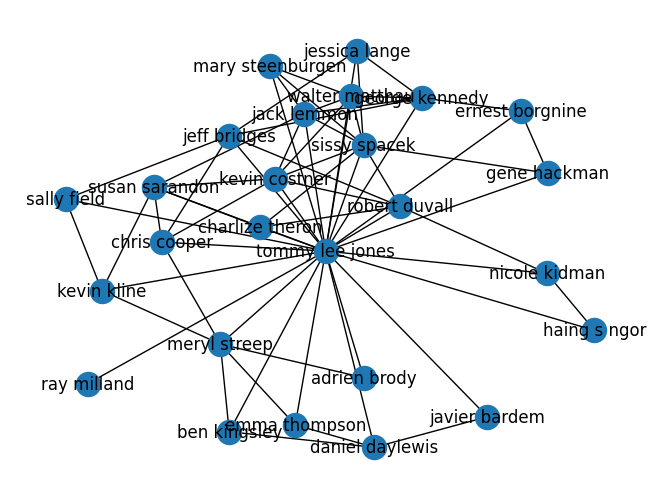

In [82]:
nx.draw_spring(subgraph, with_labels=True)

Which actors are the most important ?

As always, the answer is ... it depends. There are many ways to detect important nodes in a graph, for example based on:

Degree (generalized by Katz)
Betweeness centrality
More ...

Degree: the more people you know, the more important you are!

In [83]:
from operator import itemgetter

degrees = dict(G.degree(G.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for actor, degree in sorted_degree[:5]:
    print(actor, 'knows', degree, 'people')

gene hackman knows 43 people
charlton heston knows 42 people
john wayne knows 40 people
henry fonda knows 40 people
susan sarandon knows 38 people


t's also analyze the degree distribution. We can see that most of the people know less than 5 quakers and there are some leaders that are comparatively very popular.

<Figure size 2000x1000 with 0 Axes>

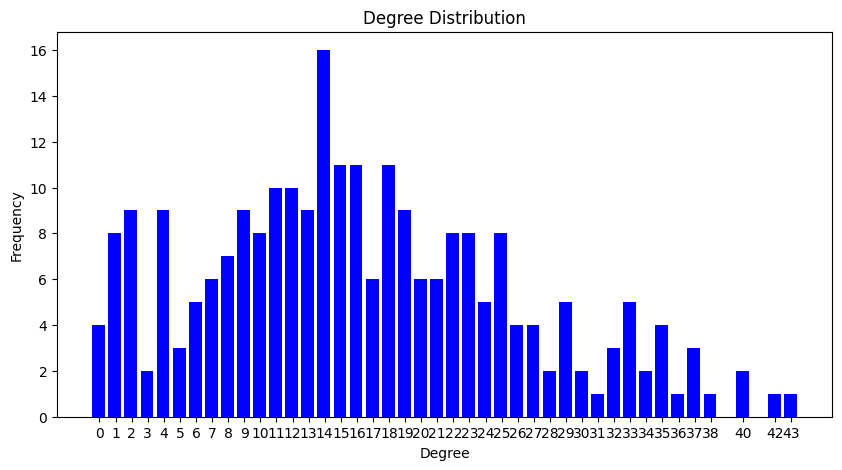

In [89]:
# As a bar plot
plot_degree_distribution(G)

Betweeness centrality: the more shortest paths pass through a node, the more important it is!

In [90]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for actor, bw in sorted_betweenness[:5]:
    print(actor, 'has betweeness: %.3f' %bw)

charlton heston has betweeness: 0.035
gene hackman has betweeness: 0.031
michael caine has betweeness: 0.027
robert duvall has betweeness: 0.027
susan sarandon has betweeness: 0.025


The node with the lowest degree is the one with the highest betweeness centrality.

This concept also translates to edges. In particular, edge betweeness is the number of shortest paths that pass through an edge. This brings us to ...
The quaker communities

Community detection is a common class of methods applied to graphs. Two important algorithms:

Girvan Newman
Louvain

Girvan Newman

Idea: Edges possessing high betweeness centrality separate communities. Let's apply this on our toy sample graph (G) to get a better understanding of the idea.

The algorithm starts with the entire graph and then it iteratively removes the edge with the highest betweeness.

The Louvain method

Another clustering algorithm and has become a standard algorithm in the data scientist toolbox.
Idea: It proceeds the other way around: initially every node is considered as a community. The communities are traversed, and for each community it is tested whether by joining it to a neighboring community, we can obtain a better clustering.



In [ ]:
from community import community_louvain

partition = community_louvain.best_partition(G)
# add it as an attribute to the nodes
for n in G.nodes:
    G.nodes[n]["louvain"] = partition[n]

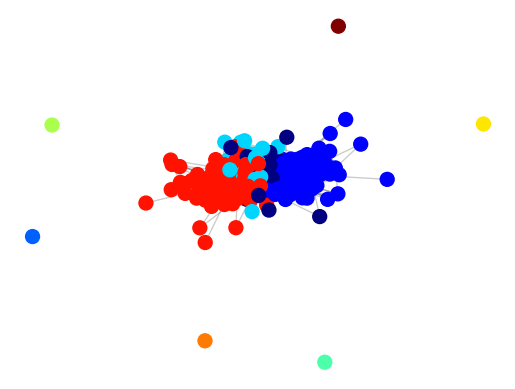

In [ ]:
# plot it out
pos = nx.spring_layout(G,k=0.2)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[G.nodes[n]["louvain"] for n in G.nodes], 
                            node_size=100, cmap=plt.cm.jet)
plt.axis('off')
plt.show()